# CS5228 Rental Prediction

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from matplotlib.colors import ListedColormap
# load data
train_data = pd.read_csv('./data/processed/train.csv')
test_data = pd.read_csv('./data/processed/test.csv')

X_train, y_train = train_data.drop(columns='monthly_rent'), train_data['monthly_rent'].copy()
X_test = test_data

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Plotting the data

In [2]:
def plot_validation_results(param_to_scores):

    plt.figure()

    param_to_validation_scores = {k: scores[1] for (k, scores) in param_to_scores.items()}
    
    # Plot the scores for each fold
    for param, scores in param_to_validation_scores.items():
        plt.scatter([param] * len(scores), scores)

    # Calculate mean and standard variation across all folds for each parameter value
    score_mean = np.array([np.mean(v) for k,v in sorted(param_to_validation_scores.items())])
    score_std = np.array([np.std(v) for k,v in sorted(param_to_validation_scores.items())])
    
    # Plot error bar
    plt.errorbar(sorted(param_to_validation_scores.keys()), score_mean, yerr=score_std)
    
    plt.xlabel('param')
    plt.ylabel('Cross-Validation RSME Score')
    plt.show()

    

def plot_scores(param_to_scores):

    plt.figure()

    param_to_training_scores = {k: scores[0] for (k, scores) in param_to_scores.items()}
    param_to_validation_scores = {k: scores[1] for (k, scores) in param_to_scores.items()}
    
    # Calculate mean and standard variation across all folds for each parameter value
    training_score_mean = np.array([np.mean(v) for k,v in sorted(param_to_training_scores.items())])
    validation_score_mean = np.array([np.mean(v) for k,v in sorted(param_to_validation_scores.items())])
    
    # Plot error bar
    plt.plot(sorted(param_to_training_scores.keys()), training_score_mean, label ='Training Score')
    plt.plot(sorted(param_to_validation_scores.keys()), validation_score_mean, label ='Validation Score')
    plt.legend(loc='lower right') 
    
    plt.xlabel('param')
    plt.ylabel('Cross-Validation RSME Score')
    plt.show()         


## Best Parameters for Gradient Boosting Regressor

In [3]:
name_GradientBoosting = 'Gradient Boosting'
params = {
    'n_estimators': 600, 
    'learning_rate': 0.03, 
    'min_samples_split': 5,
    'max_depth': 5, 
    'max_features': 'sqrt', 
    'subsample': 0.8, 
    'verbose': 1}

model_GradientBoosting = GradientBoostingRegressor(** params)
print(f'Training {name_GradientBoosting}...')

model_GradientBoosting.fit(X_train, y_train)
y_pred = model_GradientBoosting.predict(X_test)

y_train_pred = model_GradientBoosting.predict(X_train)

print(f'{name_GradientBoosting} training completed.')
result_df = pd.DataFrame({
        'Id': range(len(y_pred)),
        'Predicted': y_pred
    })
save_path = './data/predictions/' + name_GradientBoosting + '.csv'
result_df.to_csv(save_path, index=False)
print(f'{name_GradientBoosting} training result saved.\n')

print('{} evaluation:\n'.format(name_GradientBoosting))

mse_GradientBoosting = mean_squared_error(y_train, y_train_pred)
mae_GradientBoosting = mean_absolute_error(y_train, y_train_pred)
print(mse_GradientBoosting,mae_GradientBoosting)

# Calculate the RMSE based on another prediction
# pred_best = pd.read_csv('./data/predictions/Gradient Boosting.csv')
# y_pred_best = pred_best['Predicted']
# mse_GradientBoosting = mean_squared_error(y_pred, y_pred_best)
# rmse_GradientBoosting = np.sqrt(mse_GradientBoosting)
# print(rmse_GradientBoosting)

Training Gradient Boosting...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      478391.6162        8491.1163           19.11s
         2      467033.8320       17076.2497           19.78s
         3      459745.9970        3371.4461           19.95s
         4      452308.8661        5782.5115           20.08s
         5      441177.5013        3952.2432           20.45s
         6      436231.5294       12417.0567           19.90s
         7      424502.1002        1683.4921           20.31s
         8      416830.6428       12752.1958           20.74s
         9      409630.5157       10705.8385           20.66s
        10      398579.5252       -5944.4865           20.58s
        20      344838.9529        3553.7270           20.68s
        30      310691.4578       -2179.2467           20.59s
        40      287460.2263        1980.6949           20.64s
        50      269348.7259        5477.1717           20.19s
        60      259147.3236        6128

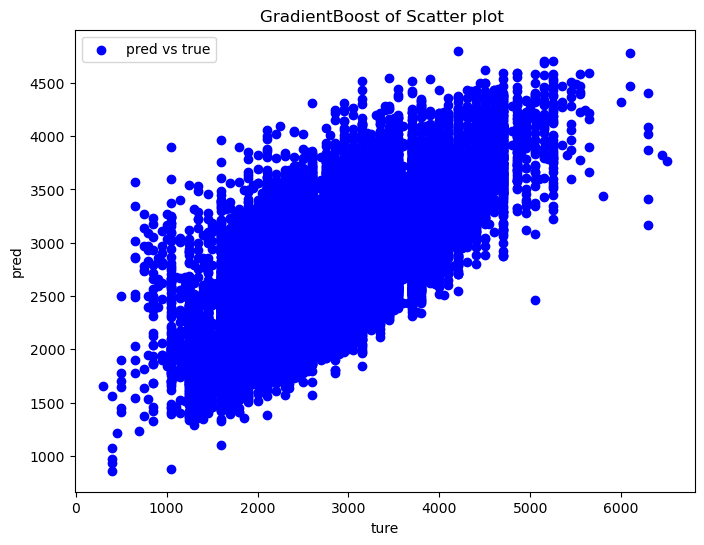

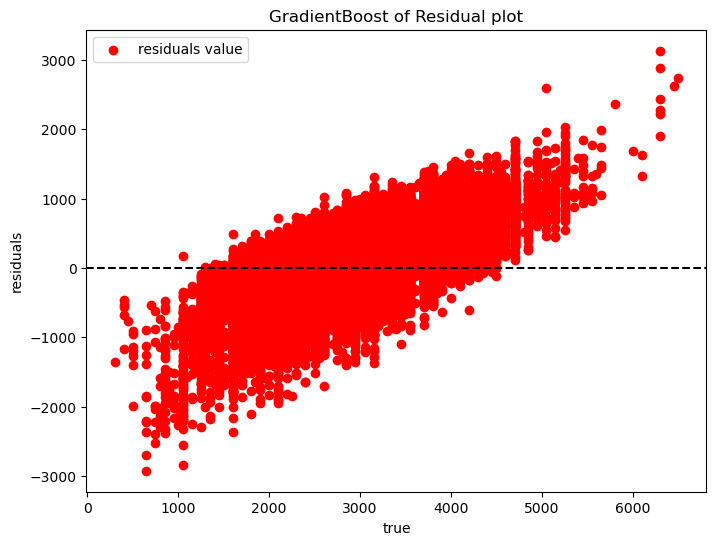

In [4]:
#Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='pred vs true')
plt.xlabel('ture')
plt.ylabel('pred')
plt.legend()
plt.title('GradientBoost of Scatter plot ')
plt.show()

# Residual plot
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_train, residuals, color='red', label='residuals value')
plt.xlabel('true')
plt.ylabel('residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title('GradientBoost of Residual plot')
plt.show()

## Grid Search for Gradient Boosting Regressor

In [22]:

# Only considered hyperparameter: max depth of trees
param_grid = {
    'n_estimators': [400, 500, 600],
    'learning_rate': [0.03, 0.05],
    'max_depth': [5, 6],
    'subsample': [0.8],
    'min_samples_split': [5],
    "max_features": ["sqrt"],
    "verbose" : [1],
}

model_GradientBoosting = GradientBoostingRegressor(random_state=42)

# for param in param_choices:
#     regressor = GradientBoostingRegressor(** params1,max_depth=param)
#     scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', return_train_score= True)
#     rsme_train = scores['train_score'] * (-1)
#     rsme_valid = scores['test_score'] * (-1)
#     param_to_scores[param] = (rsme_train, rsme_valid)
#     print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
#           .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

grid_search = GridSearchCV(model_GradientBoosting, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

# best_params_: {'learning_rate': 0.03, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 600, 'subsample': 0.8, 'verbose': 1}
# best_score_: -478.4959703927231

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      476185.2494        7064.3474           11.87s
         2      470299.0458       34011.1089           11.34s
         3      459100.5891        3627.9901           11.44s
         4      452465.3778        8529.1635           11.86s
         5      440340.9767        5592.4246           11.79s
         6      433754.4749       18193.6578           11.62s
         7      423508.3307        -793.4495           11.68s
         8      417225.6747       15957.3658           11.64s
         9      407595.2205       -2264.8667           11.59s
        10      401700.9433       10127.8786           11.48s
        20      349226.1771       10659.0798           11.21s
        30      309629.9263       -2019.1712           11.03s
        40      286598.3099         163.4106           10.68s
        50      269815.1082       10013.2561           10.39s
        60      256428.1298        1462.8168           10.23s
       

## Best Parameters for XGBoost Regressor

In [5]:
name_XGB = 'XGBRegressor'
params = {
    "n_estimators": 1000,
    "learning_rate": 0.03,
    "max_depth": 4,
    "grow_policy": "depthwise",
    "subsample": 0.8,
    "random_state" : 42
}

model_XGB = XGBRegressor(** params)
print(f'Training {name_XGB}...')

model_XGB.fit(X_train, y_train)
y_pred = model_XGB.predict(X_test)

y_train_pred = model_XGB.predict(X_train)

print(f'{name_XGB} training completed.')
result_df = pd.DataFrame({
        'Id': range(len(y_pred)),
        'Predicted': y_pred
    })
save_path = './data/predictions/' + name_XGB + '.csv'
result_df.to_csv(save_path, index=False)
print(f'{name_XGB} training result saved.\n')

print('{} evaluation:\n'.format(name_XGB))

mse_GradientBoosting = mean_squared_error(y_train, y_train_pred)
mae_GradientBoosting = mean_absolute_error(y_train, y_train_pred)
print(mse_GradientBoosting,mae_GradientBoosting)


Training XGBRegressor...
XGBRegressor training completed.
XGBRegressor training result saved.

XGBRegressor evaluation:

211225.21372055917 349.14778632578225


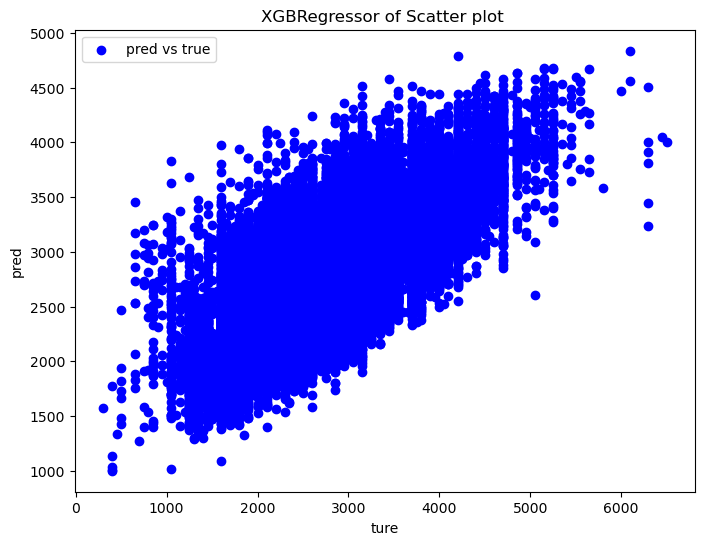

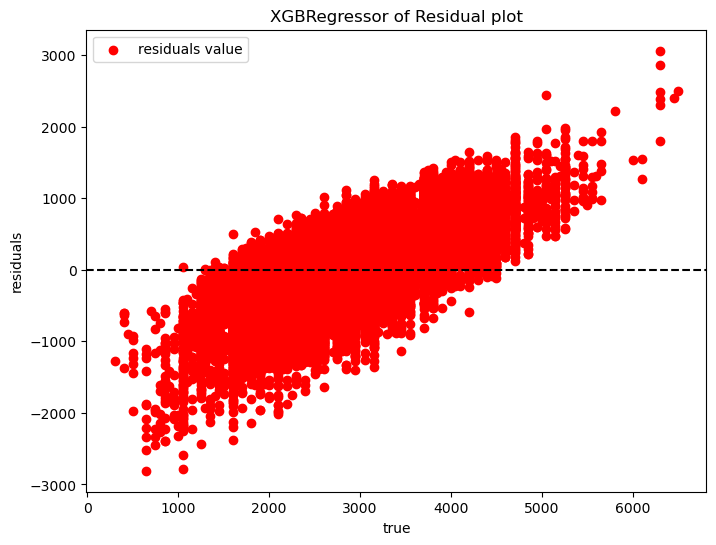

In [6]:
#Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='pred vs true')
plt.xlabel('ture')
plt.ylabel('pred')
plt.legend()
plt.title('XGBRegressor of Scatter plot ')
plt.show()

# Residual plot
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_train, residuals, color='red', label='residuals value')
plt.xlabel('true')
plt.ylabel('residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title('XGBRegressor of Residual plot')
plt.show()

## Grid Search for XGBoost Regressor

In [18]:

# Only considered hyperparameter: max depth of trees
param_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.03],
    'max_depth': [4],
    'grow_policy': ['depthwise'],
    'subsample': [0.8],
}

model_XGBRegressor = XGBRegressor(random_state=42)

# for param in param_choices:
#     regressor = GradientBoostingRegressor(** params1,max_depth=param)
#     scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', return_train_score= True)
#     rsme_train = scores['train_score'] * (-1)
#     rsme_valid = scores['test_score'] * (-1)
#     param_to_scores[param] = (rsme_train, rsme_valid)
#     print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
#           .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

grid_search = GridSearchCV(model_XGBRegressor, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

# best_params_: {'grow_policy': 'depthwise', 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.8}
# best_score_: -479.1326945958325

{'grow_policy': 'depthwise', 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.8}
-479.1326945958325


## Combine the two models

PS: This is the best model we have found so far.

In [7]:
# Combined model
name_combined = 'Combined'

# Combine the predictions of the two models: Gradient Boosting and XGBRegressor
# read the predictions
pred_GradientBoosting = pd.read_csv('./data/predictions/Gradient Boosting.csv')
pred_XGB = pd.read_csv('./data/predictions/XGBRegressor.csv')
y_pred_GradientBoosting = pred_GradientBoosting['Predicted']
y_pred_XGB = pred_XGB['Predicted']

# Combine the predictions
y_pred_combined = 0.5 * y_pred_GradientBoosting + 0.5 * y_pred_XGB

# Save the combined predictions
result_df = pd.DataFrame({
        'Id': range(len(y_pred_combined)),
        'Predicted': y_pred_combined
    })
save_path = './data/predictions/' + name_combined + '.csv'
result_df.to_csv(save_path, index=False)
print(f'{name_combined} training result saved.\n')

Combined training result saved.

